In [1]:
import spacy
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
from keras.models import model_from_json

# from AttentionModule import SelfAttention, SoftAttention
import os
visible_gpu_devices = '0,1,3'
os.environ["CUDA_VISIBLE_DEVICES"]=visible_gpu_devices
import cv2
from tqdm.notebook import tqdm
import AttentionMed as AM
from importlib import reload
reload(AM)
from time import time,localtime,strftime
from ipywidgets import IntProgress
# from coord import CoordinateChannel2D

Using TensorFlow backend.


In [2]:
n_gpu=len(visible_gpu_devices.split(','))
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [3]:
def multiheadSelfAttention(prev_layer,layer_number=0,heads=8):
    assert prev_layer != None
    sa_arr = []
    for head in range(heads):
        sa,samap = AM.SelfAttention(ch=int(prev_layer.shape[-1]),name='sa{0}{1}'.format(layer_number,head))(prev_layer)
        sa = kl.BatchNormalization()(sa)
        sa_arr.append(sa)
    return sa_arr
def multiheadAttention(prev_layer,context_vector,layer_number=0,heads=8):
    assert prev_layer != None
    assert context_vector != None
    a_arr = []
    for head in range(heads):
        a,a_map = AM.Attention(ch=int(prev_layer.shape[-1]),timesteps=1,name='a{0}{1}'.format(layer_number,head))([context_vector,prev_layer])
        a = kl.BatchNormalization()(a)
        a_arr.append(a)
    return a_arr
def feedforwardsa(sa_layer,layer_before_sa,out_channels,layer_number=0,method='add'):
    x = kl.Concatenate(name='concat_selfattn_{0}'.format(layer_number))(sa_layer)
    x = AM.CondenseAttention1D(ch_in=int(x.shape[-1]),ch_out=out_channels)(x)
    x, g1, g2 = AM.ResidualCombine(method=method
                                   ,name='residual_combine_selfattn_{0}'.format(layer_number))([layer_before_sa, x])
    x = kl.BatchNormalization()(x)
    return x
def feedforwarda(a_layer,context_vector,out_channels,layer_number=0,method='add'):
    x = kl.Concatenate(name='concat_attn_{0}'.format(layer_number))(a_layer)
    x = AM.CondenseAttention1D(ch_in=int(x.shape[-1]),ch_out=out_channels)(x)
    x = kl.Lambda(lambda x:K.squeeze(x,axis=1),name="squeeze_attn_{0}".format(layer_number))(x)
    x, g1, g2 = AM.ResidualCombine(method=method
                                   ,name='residual_combine_attn_{0}'.format(layer_number))([context_vector, x])
    x = kl.BatchNormalization()(x)
    return x

In [4]:
nlp = spacy.load('en_core_web_md')

In [5]:
path=os.getcwd() #Get the path
path

'/media/MyDataStor1/mshaikh2/project_xray/ChestXRay/notebooks'

In [6]:
merged_ds = pd.read_csv('../../dataset/descriptions/region_descriptions_50000.csv')

In [7]:
# sent_len_arr=[]
# wo_len_arr = []
# for row in tqdm(merged_ds['impression'].values):
#     doc = nlp(row)
#     sentences = [sent.string.strip() for sent in doc.sents]
#     sent_len_arr.append(len(sentences))
#     sentence = ' '.join(sentences[:7])
#     sdoc = nlp(sentence)
#     ls_sdoc = [str(x) for x in list(sdoc)]
#     wo_len_arr.append(len(ls_sdoc))

In [8]:

# df_sent_len = pd.DataFrame(sent_len_arr,columns=['count'])
# df_word_len = pd.DataFrame(wo_len_arr,columns=['count'])
# df_sent_len.shape,df_word_len.shape

In [9]:
# df_word_len.describe()

In [10]:
# df_sent_len[df_sent_len['count']>7].shape
# df_word_len[df_word_len['count']>20]


In [11]:
# ch_to_co = df_ccount
# ch_to_co.index = ch_to_co.chars
# ch_to_co = ch_to_co['index'].to_dict()
# display(ch_to_co)
# co_to_ch = df_ccount
# co_to_ch.index = co_to_ch['index']
# co_to_ch = co_to_ch['chars'].to_dict()
# display(co_to_ch)

In [12]:
# tokens = nlp('startseq ' 
#              + ' '.join(c_repo_ds.impression.values).lower().replace('/',' ')
#              + ' endseq.' 
#              + ' startseq' 
#              + ' '.join(c_repo_ds.findings.values).lower().replace('/',' ')
#              + ' endseq.')

In [13]:
# vocab = [str(x) for x in tokens]
# vocab

In [14]:
# word_count = {}
# for word in vocab:
#     if word not in word_count.keys():
#         word_count[word]=1
#     else:
#         word_count[word]+=1
# df_wcount = pd.DataFrame()
# df_wcount['words']=word_count.keys()
# df_wcount['w_count']=word_count.values()
# df_wcount = df_wcount.sort_values(by='w_count',ascending=False).reset_index()
# df_wcount['index']+=1

# df_wcount.to_csv('../dataset/vocab_count.csv',index=False)
df_wcount = pd.read_csv('../../dataset/descriptions/visual_genome_vocab_count.csv')

display(df_wcount)
vocab_size=df_wcount.shape[0]
max_wlen = 60
print(vocab_size,max_wlen)

,index,words,w_count
0,3434,.,450076
1,13908,a,200676
2,14934,the,198458
3,16021,on,122073
4,10923,of,88941
5,15692,is,74203
6,11138,in,61882
7,6384,white,59361
8,1829,..,57700
9,18441,black,37028


20794 60


In [15]:
new_words= [word for word in df_wcount['words'].values if not word.isalnum()]
print(len(new_words),new_words)

597 ['.', '..', "'s", ' ', ',', '-', '"', "'", '&', '/', 'w/', '[', '\n', '@', "n't", ']', '?', ':', ';', 'p.', 't.v', '...', '  ', '!', '$', '_', 'w.', 'u.s', 'n.', 'a.', "o'clock", 'c.', '#', 'x.', '(', 'r.', ')', 'e.', 's.', 't.', 'b.', '1/2', 'l.', 'man`s', 'woman`s', 'm.', 'c-130', '=', 'black+white', '   ', '....', 'and/or', 'o.', 'red+white', 'dog`s', 'i.', 'girl`s', 'v.', 'm&m', 'g.', '......', 'f.', '+', '.....', 'sr-71', 'y.', "'m", 'co.', 'h.', 'cow`s', 'j.', 'd.', '`', 'boy`s', '%', 'man;s', '--', '\n\n', 't-', '2:35', '1:45', 'u.', 'w/o', 'red+black', 'at&t', '11:50am', '1.00', '12:00', '3:17', '7:05', "'re", 'brown+white', '1/3', 'back+one', 'i.d', '/or', '1:55', 'green+white', '10:50', '12:43', '                                    ', 'b+w', '4-post', 'child`s', '11:20', '3:00', 'trunk+branches', '12:40', 'www.myprofe.com', 'person`s', 'k.', 'catcher`s', '9.99', 'free!.', '    ', 'a&m', '3-way', '3:55', 'sea+sky', '11:05', '4-way', '2:20', 'tool+a', 'house/', 'him!.', '11

In [16]:
w_to_co = df_wcount
w_to_co.index = w_to_co.words
w_to_co = w_to_co['index'].to_dict()
# print(w_to_co)
co_to_w = df_wcount
co_to_w.index = co_to_w['index']
co_to_w = co_to_w['words'].to_dict()
# print(co_to_w)

In [17]:
# df = pd.DataFrame(sorted(finding_len,reverse=True))
# display(df.head(50))
# df.plot(kind='hist',figsize=(6,6))
co_to_w[13]

'troaster'

In [18]:
embedding_size = 300
# embedding_matrix = np.zeros((vocab_size+1, embedding_size)) # last one : to cater to empty/-1
# for word,idx in w_to_co.items():
#     token = nlp(word)
#     embedding_matrix[idx] = token.vector
# embedding_matrix[vocab_size] = np.zeros(embedding_size)
embedding_matrix = pd.read_pickle('../../dataset/descriptions/visual_genome_initial_emb_mat.p')
embedding_matrix = embedding_matrix.values
# print(embedding_matrix.shape)
# df_emb = pd.DataFrame(embedding_matrix)
# df_emb.to_pickle('../dataset/initial_emb_mat.p')

# Parameters

In [19]:
img_arch = 'vgg'
text_arch = '1dcnn'
model_name = '{0}_{1}_text_img_attention'.format(img_arch,text_arch)
EPOCHS = 50
lr = 0.0001
img_dropout_rate=0.5
text_dropout_rate=0.5
elu_alpha = 1.0

# Model Initialization

In [20]:
def VGGNet():
    image_input = Input(shape=(256,256,3),name='image_input')
    # x = CoordinateChannel2D()(inp)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv1')(image_input)
    x = kl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', name='block1_conv2')(x)
    x = kl.Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same', name='block1_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv1')(x)
    x = kl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', name='block2_conv2')(x)
    x = kl.Conv2D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same', name='block2_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv1')(x)
    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv2')(x)
    x = kl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', name='block3_conv3')(x)
    x = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv1')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv2')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block4_conv3')(x)
    # x = CoordinateChannel2D(use_radius=True)(x)
#     x, samap, g = SelfAttention(ch=512, name='self_attention')(x)
    x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(img_dropout_rate)(x)

    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv1')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv2')(x)
    x = kl.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', name='block5_conv3')(x)
#     x, amaps = SoftAttention(ch=512, m=32, name='soft_attention')(x)
    x = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(x)
    return Model(image_input,x,name='imgModel')
# def DenseNet():
#     qw = Input(shape=(256,256,3),name='image_input')
#     qw_1 = kl.Conv2D(strides=1,padding='valid',activation='relu',filters=64,name='conv',kernel_size=3)(qw)

#     qw_1 = densenet.densenet.conv_block(x=qw_1,growth_rate=64,name='conv_1',)

#     qw_2 = densenet.densenet.dense_block(qw_1,blocks=1,name='block_1')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     qw_2 = kl.Conv2D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same', name='block1_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_2')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=128, kernel_size=2, strides=2, activation='relu', padding='same', name='block2_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_3')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=256, kernel_size=2, strides=2, activation='relu', padding='same', name='block3_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_4')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=512, kernel_size=2, strides=2, activation='relu', padding='same', name='block4_reduction_conv')(qw_2)
#     qw_2 = kl.Dropout(0.5)(qw_2)

#     qw_2 = densenet.densenet.dense_block(qw_2,blocks=1,name='block_5')
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)
#     # qw_2 = kl.MaxPool2D(pool_size=2)(qw_2)
#     qw_2 = kl.Conv2D(filters=1024, kernel_size=2, strides=2, activation='relu', padding='same', name='block5_reduction_conv')(qw_2)
#     # qw_2 = kl.Dropout(0.5)(qw_2)
#     qw_2 = kl.BatchNormalization()(qw_2)
#     qw_2 = kl.Activation('relu')(qw_2)

#     return Model(qw,qw_2, name='imgModel')

In [21]:
if img_arch=='vgg':
#     imgNet = VGGNet()
    imgNet = VGG16(include_top=False,input_shape=(256,256,3),weights='imagenet')
elif img_arch == 'densenet121':
    imgNet = DenseNet121(include_top=False,input_shape=(256,256,3))
    imgNet.trainable = True
elif img_arch == 'densenet':
    imgNet = DenseNet()
elif img_arch == 'irv2':
    imgNet =InceptionResNetV2(include_top=False,input_shape=(256,256,3))
    imgNet.trainable = True
# if os.path.exists('../checkpoints/{0}_{1}_attention_img_module.h5'.format(img_arch,text_arch)):
#     print('loading existing image weights..')
#     imgNet.load_weights('../checkpoints/{0}_{1}_attention_img_module.h5'.format(img_arch,text_arch))
imgNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [22]:
bottleneck_units = 512
def getTextNet():
    words_input = kl.Input(shape=(max_wlen,),name='words_input')
#     padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
    emb = kl.Embedding(vocab_size+1, embedding_size, mask_zero=False, name='w2v_emb')(words_input)
    c1 = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=3,padding='same')(emb)
    c2 = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=3,dilation_rate=2,padding='same')(emb)
    c3 = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=5,padding='same')(emb)
    c4 = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=5,dilation_rate=2,padding='same')(emb)
    c5 = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=7,padding='same')(emb)
    c6 = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=7,dilation_rate=2,padding='same')(emb)
    emb = kl.Concatenate(axis=-1)([c1,c2,c3,c4,c5,c6])
    emb = kl.Conv1D(embedding_size,activation='relu',strides=1,kernel_size=1,padding='same')(emb)
    emb = kl.BatchNormalization()(emb)
    
    sa = multiheadSelfAttention(prev_layer=emb,layer_number=1,heads=8)
    sa_ff = feedforwardsa(sa_layer=sa,layer_before_sa=emb,layer_number=1,method='add',out_channels=int(emb.shape[-1]))

    sa = multiheadSelfAttention(prev_layer=sa_ff,layer_number=2,heads=8)
    sa_ff = feedforwardsa(sa_layer=sa,layer_before_sa=sa_ff,layer_number=2,method='add',out_channels=int(sa_ff.shape[-1]))

    sa = multiheadSelfAttention(prev_layer=sa_ff,layer_number=3,heads=8)
    sa_ff = feedforwardsa(sa_layer=sa,layer_before_sa=sa_ff,layer_number=3,method='add',out_channels=int(sa_ff.shape[-1]))
    
    sa = multiheadSelfAttention(prev_layer=sa_ff,layer_number=4,heads=8)
    sa_ff = feedforwardsa(sa_layer=sa,layer_before_sa=sa_ff,layer_number=4,method='add',out_channels=int(sa_ff.shape[-1]))
    
    context_vector = kl.GlobalAveragePooling1D(name='gap')(sa_ff)

    a = multiheadAttention(prev_layer=sa_ff,context_vector=context_vector,layer_number=1,heads=8)
    a_ff = feedforwarda(a_layer=a,context_vector=context_vector,out_channels=int(emb.shape[-1]),layer_number=1,method='add')
    output = kl.Dense(512,name='text_context')(a_ff)
    return Model([words_input],output,name='textModel')

In [23]:
textNet = None

In [24]:
textNet = getTextNet()
textNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
w2v_emb (Embedding)             (None, 60, 300)      6238500     words_input[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 300)      270300      w2v_emb[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 300)      270300      w2v_emb[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (

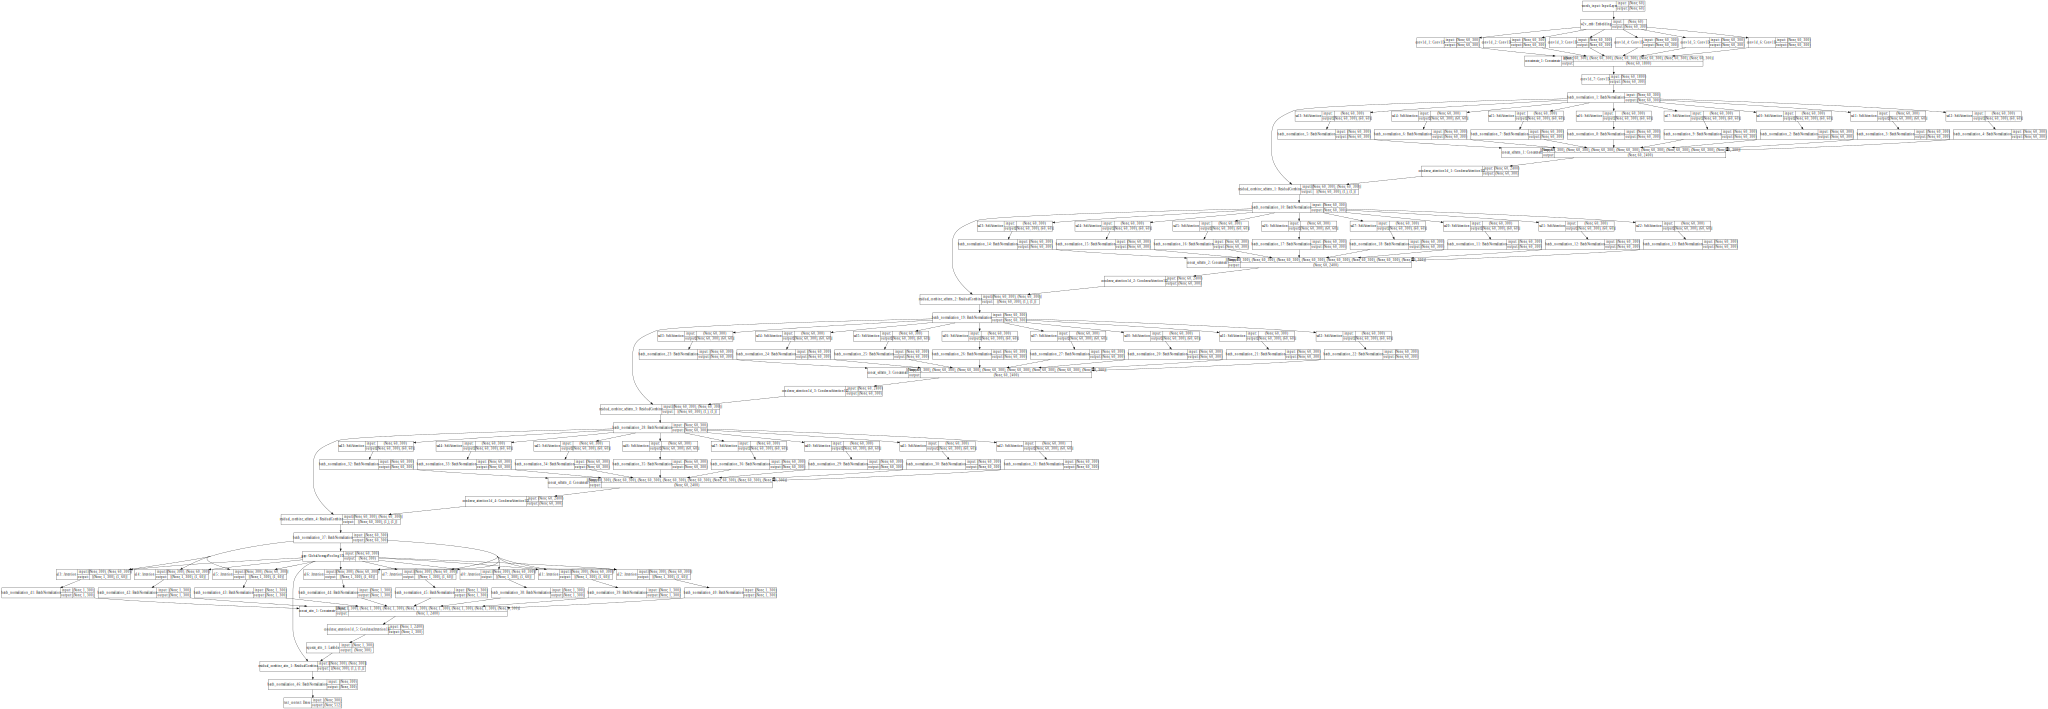

In [25]:
SVG(model_to_dot(textNet, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# Define Complete Joint Network

In [26]:
image_dropout_rate = 0.3
image_input = kl.Input(shape=(256,256,3),name='image_input')
image_features = imgNet(image_input)
image_features = kl.Dropout(image_dropout_rate)(image_features)

text_dropout_rate = 0.1
# padding_masks = kl.Input(shape=(max_wlen,1),name='padding_masks')
words_input = kl.Input(shape=(max_wlen,),name='words_input')
text_features = textNet([words_input])
text_features = kl.Dropout(text_dropout_rate)(text_features)
print(image_features.shape)
print(text_features.shape)

(?, 8, 8, 512)
(?, 512)


In [27]:
# a_out_im_1,beta_im_1 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_1')([image_features,text_features,padding_masks])
# # a_out_im_1 = kl.BatchNormalization()(a_out_im_1)
# # a_out_im_1 = kl.ELU(alpha=elu_alpha)(a_out_im_1)
# a_out_im_2,beta_im_2 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_2')([image_features,text_features,padding_masks])
# # a_out_im_2 = kl.BatchNormalization()(a_out_im_2)
# # a_out_im_2 = kl.ELU(alpha=elu_alpha)(a_out_im_2)
# a_out_im_3,beta_im_3 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_3')([image_features,text_features,padding_masks])
# # a_out_im_3 = kl.BatchNormalization()(a_out_im_3)
# # a_out_im_3 = kl.ELU(alpha=elu_alpha)(a_out_im_3)
# a_out_im_4,beta_im_4 = AM.Img2TextCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='img2text_4')([image_features,text_features,padding_masks])
# # a_out_im_4 = kl.BatchNormalization()(a_out_im_4)
# # a_out_im_4 = kl.ELU(alpha=elu_alpha)(a_out_im_4)
# a_conc_images = kl.Concatenate(name='img2text_concat')([a_out_im_1,a_out_im_2,a_out_im_3,a_out_im_4])
# # a_conc_im_out = kl.BatchNormalization()(a_conc_im_out)
# # print('a_conc_im_out.shape:',a_conc_im_out.shape)

# img2text_condense = AM.CondenseAttention2D(ch_in=int(a_conc_images.shape[-1]),ch_out=512)(a_conc_images)
# img2text_comb, xi2tg1, xi2tg2 = AM.ResidualCombine()([image_features, img2text_condense])
# img2text_comb = kl.ELU(alpha=elu_alpha)(img2text_comb)
# img2text_comb = kl.Conv2D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(img2text_comb)
# img2text_comb = kl.BatchNormalization()(img2text_comb)
# img2text_comb = kl.Dropout(dropout_rate)(img2text_comb)
img2text_pool = kl.GlobalAveragePooling2D(name='img2text_global_pool')(image_features)


In [28]:
# a_out_1,beta_1 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_1')([text_features,image_features,padding_masks])
# # a_out_1 = kl.BatchNormalization()(a_out_1)
# # a_out_1 = kl.ELU(alpha=elu_alpha)(a_out_1)
# # print(a_out_1.shape)
# a_out_2,beta_2 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_2')([text_features,image_features,padding_masks])
# # a_out_2 = kl.BatchNormalization()(a_out_2)
# # a_out_2 = kl.ELU(alpha=elu_alpha)(a_out_2)
# # print(a_out_2.shape)
# a_out_3,beta_3 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_3')([text_features,image_features,padding_masks])
# # a_out_3 = kl.BatchNormalization()(a_out_3)
# # a_out_3 = kl.ELU(alpha=elu_alpha)(a_out_3)
# # print(a_out_3.shape)
# a_out_4,beta_4 = AM.Text2ImgCA(text_ch=int(text_features.shape[-1]),img_ch=int(image_features.shape[-1]),name='text2img_4')([text_features,image_features,padding_masks])
# # a_out_4 = kl.BatchNormalization()(a_out_4)
# # a_out_4 = kl.ELU(alpha=elu_alpha)(a_out_4)
# # print(a_out_4.shape)
# a_conc_text = kl.Concatenate(name='text2img_concat')([a_out_1,a_out_2,a_out_3,a_out_4])

# text2img_condense = AM.CondenseAttention1D(ch_in=int(a_conc_text.shape[-1]),ch_out=512)(a_conc_text)
# text2img_comb, xt2ig1, xt2ig2 = AM.ResidualCombine()([text_features, text2img_condense])
# text2img_comb = kl.ELU(alpha=elu_alpha)(text2img_comb)
# text2img_comb = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(text2img_comb)
# text2img_comb = kl.BatchNormalization()(text2img_comb)
# text2img_comb = kl.Dropout(dropout_rate)(text2img_comb)
# text2img_pool = kl.GlobalAveragePooling1D(name='text2img_global_pool')(text_features)
text2img_pool = text_features

In [29]:
dropout_rate = 0.3
all_concat = kl.Concatenate()([img2text_pool,text2img_pool])
cross_pool = kl.Dense(1024,activation='relu')(all_concat)
cross_pool = kl.Dense(512,activation='relu')(cross_pool)
cross_pool = kl.Dropout(dropout_rate)(cross_pool)
target = kl.Dense(vocab_size+1, activation='softmax',name='target_word')(cross_pool)
model = Model([image_input,words_input],target)


In [30]:
# json_file = open('../model_json/{0}_{1}_text_img_attention.json'.format(img_arch,text_arch), 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

In [31]:
# loaded_model_json

In [32]:
# loaded_model==model

In [33]:
l = textNet.get_layer('w2v_emb')
l.set_weights([embedding_matrix])
l.trainable = True
# if not os.path.exists('../checkpoints/{0}.h5'.format(model_name)):
#     print('New model {0}.'.format(model_name))
# else:
#     print('Existing model {0}. trained weights will be loaded'.format(model_name))
#     model.load_weights('../checkpoints/{0}.h5'.format(model_name), skip_mismatch=True, by_name=True)
# l.trainable = True

In [34]:
# w_to_co
# textNet.load_weights('../checkpoints/irv2_1dcnn_attention_text_module.h5')
# imgNet.load_weights('../checkpoints/irv2_1dcnn_attention_img_module.h5')

In [35]:

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr),metrics=['accuracy'])
# model.load_weights('../checkpoints/{0}.h5'.format(model_name))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 8, 8, 512)    14714688    image_input[0][0]                
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 8, 8, 512)    0           vgg16[1][0]                      
__________________________________________________________________________________________________
textModel 

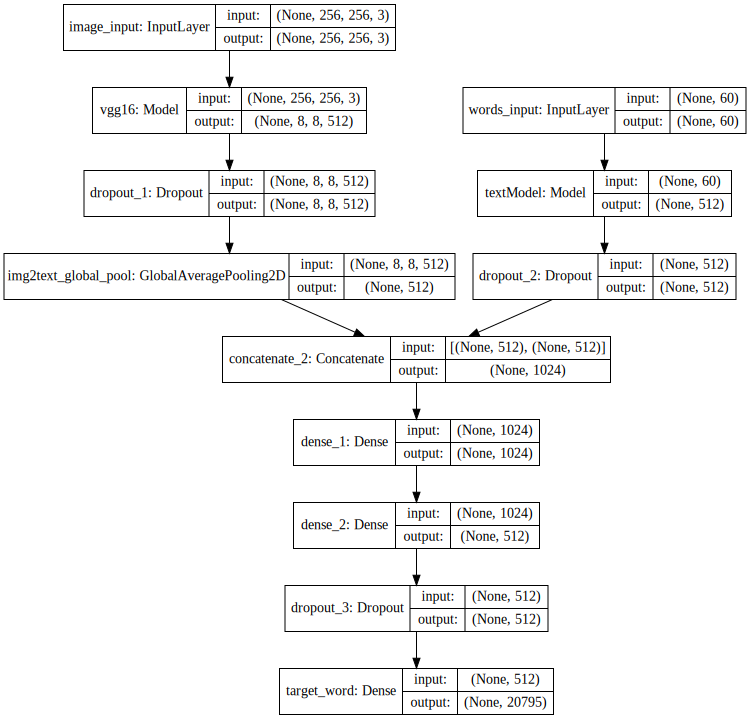

In [36]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


In [37]:
model_json = model.to_json()
with open("../model_json/visual_genome_{0}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)


In [38]:
model_name

'vgg_1dcnn_text_img_attention'

In [39]:
emb = Model(textNet.inputs[0],textNet.get_layer('w2v_emb').output)
emb.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words_input (InputLayer)     (None, 60)                0         
_________________________________________________________________
w2v_emb (Embedding)          (None, 60, 300)           6238500   
Total params: 6,238,500
Trainable params: 6,238,500
Non-trainable params: 0
_________________________________________________________________


In [40]:
def datagen(img_lst,batch_size=4):
    counter=0
    x1,x2,y,sents,masks, img_names = [],[],[],[],[],[]
    idx = 0
    while True:
        im = img_lst[idx]
#         print(im)
        photo = cv2.resize(cv2.imread('../../dataset/train_images/VG_100K/{0}.jpg'.format(im)),(256,256),cv2.INTER_CUBIC)
        photo = photo/255.0
    
#         print(merged_ds[merged_ds.filename==im])
        sent = merged_ds[merged_ds.ID==im]['Desc'].values[0].lower()
        
        ts = nlp(sent)
#         print(ts)
        ts = [str(x) for x in list(ts)]
#         print(tss)
        ts = ts[:max_wlen-1]
        sent_words = ['startseq']
        for t in ts:
#             print(t)
#             t = 'sdadasasdasads'
            if (t not in w_to_co.keys()) : #or ('xx' in t):
#                 print('not present:',t)
                pass
            else:
                sent_words.append(t)
        sent_words.append('endseq')
#         print(sent_words)

        seq = [w_to_co[x] for x in sent_words]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]
#             print(out_seq)
            in_seq = sequence.pad_sequences([in_seq], maxlen=max_wlen,padding='pre',value=0)[0]
            mask = [0.001 if x<1 else  1 for x in in_seq]
            mask = np.expand_dims(mask,-1)
            out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size+1)[0]
            x1.append(photo)
            img_names.append('{0}.jpg'.format(im))
            x2.append(in_seq)
            masks.append(mask)
            y.append(out_seq)
            sents.append(sent)
        counter+=1
        idx+=1
#         print(idx)
        if idx==len(img_lst):
            idx=0
        if counter==batch_size:
            counter=0
            inputs = {'image_input': np.array(x1),
                      'words_input': np.array(x2),
                      'padding_masks':np.array(masks),
                      'image_names':np.array(img_names)
                     }
            outputs = {'target_word':np.array(y),
                      'actual_sentence':np.array(sents)}
            yield inputs, outputs
            x1,x2,y,sents,masks,img_names = [],[],[],[],[],[]

In [41]:


with open('../../dataset/descriptions/visual_genome_train_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    train_images_list = pickle.load(filehandle)
with open('../../dataset/descriptions/visual_genome_val_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    val_images_list = pickle.load(filehandle)
with open('../../dataset/descriptions/visual_genome_test_images.p', 'rb') as filehandle:
    # read the data as binary data stream
    test_images_list = pickle.load(filehandle)
# train_images_list=list(train_images_list)+list(val_images_list)
print('train:',len(train_images_list),
      '+ val:',len(val_images_list),
      '+ test:',len(test_images_list),
      ' = ',(len(train_images_list)+len(val_images_list)+len(test_images_list)))
train_batch_size = 64
val_batch_size = 64
test_batch_size = 1
train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)
test_gen = datagen(test_images_list,batch_size=test_batch_size)

train: 35000 + val: 10000 + test: 5000  =  50000


In [42]:
# # test_images_list = merged_ds.filename.values
# # test_images_list = list(test_images_list)
# # for x in train_images_list:
# #     test_images_list.remove(x)
# # for x in val_images_list:
# #     test_images_list.remove(x)
# # len(test_images_list)
# imgs = merged_ds.ID.values
# imgs

In [43]:

# np.random.shuffle(imgs)

# train_images_list = imgs[:int(0.7*len(imgs))]
# val_images_list = imgs[int(0.7*len(imgs)):int(0.9*len(imgs))]
# test_images_list = imgs[int(0.9*len(imgs)):]
# train_images_list.shape,val_images_list.shape,test_images_list.shape
# with open('../../dataset/descriptions/visual_genome_train_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(train_images_list, file)
# with open('../../dataset/descriptions/visual_genome_val_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(val_images_list, file)
# with open('../../dataset/descriptions/visual_genome_test_images.p', 'wb') as file:
#     # store the data as binary data stream
#     pickle.dump(test_images_list, file)
# # # tx,ty = next(train_gen)
# # # tx['padding_masks'][30].shape

In [44]:

# display(tx['image_input'].shape
#         ,tx['words_input'][30]
#         ,tx['padding_masks'][30]
#         ,' '.join([co_to_w[x] if x !=0 else '' for x in tx['words_input'][30]])
#         ,ty['actual_sentence'][30])
# train_images_list=list(train_images_list)+list(val_images_list)

In [45]:
len(test_images_list),len(train_images_list)

(5000, 35000)

In [46]:
# # def _ctc_lambda_func(args):
# #     labels, y_pred, input_length, label_length = args
# #     return K.tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
# vggnet.summary()
# w_to_co['xxxx']

# np.clip(0,a_max=1,a_min=1e-8)

In [47]:
# print(co_to_w[273])
# print(embedding_matrix[1380])
# for u,v in zip(tx['words_input'][0],tx['padding_masks'][0]):
#     print(u,v)
merged_ds.head()

,ID,Desc
0,1,the clock is green in colour. shade is along t...
1,2,walk sign is lit up. man wearing silver backpa...
2,3,multi-line office phone system. electrical and...
3,4,Blue curtains with sailboats on them. A black ...
4,5,the floor is wooden. white cables are on the f...


In [48]:
# att = np.random.randint(1,10,(4,5,5))
# mask = 1-np.triu(np.ones((4,5,5)),k=1)
# att*mask
vx,vy = next(val_gen)

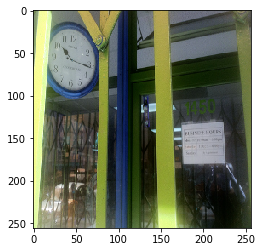

In [49]:
img = vx['image_input'][0]
plt.imshow(img)

In [50]:
for i in range(200):
    print('---',i,'---')
    print('['+vx['image_names'][i]+'], input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(vx['words_input'][i],vx['padding_masks'][i])]),', \t next_word:',co_to_w[np.argmax(vy['target_word'][i])])

--- 0 ---
[2370764.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <startseq> [1.] , 	 

[2370764.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <startseq> [1.], <a> [1.], <clock> [1.], <mounted> [1.], <to> [1.], <a> [1.], <wall> [1.], <.> [1.], <a> [1.], <sign> [1.], <on> [1.], <a> [1.], <wall> [1.], <.> [1.], <a> [1.], <blue> [1.], <support> [1.], <beam> [1.], <.> [1.], <a> [1.], <wooden> [1.], <pillar> [1.], <in> [1.], <a> [1.], <building> [1.], <.> [1.], <bars> [1.], <across> [1.], <a> [1.], <window> [1.], <.> [1.], <a> [1.], <light> [1.], <in> [1.] , 	 next_word: a
--- 34 ---
[2370764.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0

[2391849.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <startseq> [1.], <two> [1.], <directional> [1.], <signs> [1.], <over> [1.], <highway> [1.], <.> [1.], <bridge> [1.], <over> [1.], <highway> [1.], <in> [1.], <photo> [1.], <.> [1.], <golden> [1.], <dog> [1.], <being> [1.], <walked> [1.], <on> [1.], <leash> [1.], <.> [1.] , 	 next_word: many
--- 80 ---
[2391849.jpg], input_seq: <None>

[2385100.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <startseq> [1.], <people> [1.], <walking> [1.], <a> [1.], <curved> [1.] , 	 next_word: and
---

[2385100.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <startseq> [1.], <people> [1.], <walking> [1.], <a> [1.], <curved> [1.], <and> [1.], <steep> [1.], <sidewalk> [1.], <.> [1.], <round> [1.], <traffic> [1.], <signs> [1.], <on> [1.], <a> [1.], <pole> [1.], <.> [1.], <metal> [1.], <railing> [1.], <on> [1.], <inside> [1.], <of> [1.], <curb> [1.], <.> [1.], <trees> [1.], <on> [1.], <top> [1.], <of> [1.], <plant> [1.], <-> [1.], <covered> [1.], <slope> [1.], <.> [1.], <woman> [1.], <using> [1.], <open> [1.], <umbrella> [1.], <on> [1.], <sunny> [1.], <day> [1.], <.> [1.], <cars> [1.], <parked> [1.], <on> [1.], <side> [1.], <of> [1.], <street> [1.], <.> [1.], <windowed> [1.], <building> [1.] , 	 next_word: seen
--- 169 ---
[2385100.jpg], input_seq: <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <None> [0.001], <N

In [51]:
# print(vx['words_input'][1])
# embedding_matrix[105]
embedding_matrix[w_to_co['..']]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [52]:
emb_out = emb.predict(vx['words_input'])
emb_out[1][-2]

array([ 0.13219371, -0.19465026, -0.02212655, -0.01758797, -0.05859465,
        0.24596591,  0.07678664,  0.28997082,  0.36150724,  0.36563286,
        0.34160966, -0.06796359, -0.4269016 ,  0.1151577 , -0.18047696,
        0.03713265, -0.06325483,  0.19014561,  0.380982  ,  0.40779996,
       -0.49013612,  0.08590927, -0.47230223, -0.28045982, -0.20878564,
       -0.26647165, -0.02364772,  0.1321182 ,  0.00495375,  0.47253942,
        0.371364  , -0.08130746,  0.16136836, -0.03925774, -0.2358193 ,
        0.03646893,  0.19255431,  0.2636729 , -0.23412222,  0.02633012,
       -0.25536558,  0.15751627,  0.49496353,  0.30594635, -0.00513036,
       -0.3109869 , -0.44936153,  0.25010687,  0.0480016 , -0.21161744,
       -0.13679051,  0.49585474,  0.06696449, -0.37588006, -0.19318876,
       -0.05119455,  0.2996295 , -0.15990216, -0.3082852 ,  0.29220897,
       -0.33740854,  0.03839038, -0.0969456 ,  0.4329269 ,  0.25184602,
        0.34867814,  0.02990294,  0.47961974,  0.44659117,  0.01

In [53]:
parallel_model=multi_gpu_model(model, gpus=n_gpu)
# # model_resnet.summary()
# # parallel_model.load_weights('./../checkpoints/sa_vgg16_3d_32x24_m32_direct.h5', by_name=True, skip_mismatch=True)

In [54]:
lr=0.01
parallel_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr),metrics=['accuracy']) #For multi GPU
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 60)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 60)           0           words_input[0][0]                
__________________________________________________________________________________________________
lambda_3 (

In [55]:
# mc=ModelCheckpoint(filepath='../checkpoints/vgg16_lstm_words.h5',monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
# es=EarlyStopping(patience=300,monitor='val_loss',min_delta=0.0001,mode='auto')

print('training {0} for {1} epochs'.format(model_name,EPOCHS))
# lr = K.eval(parallel_model.optimizer.lr)
# decay = 1e-3

training vgg_1dcnn_text_img_attention for 50 epochs


In [56]:
def CheckSelfAttention(input_data,labels):
    words_input,padding_masks=input_data
    for i in range(words_input.shape[0]):
        print('-*-*-',i,'-*-*-')
        print('input_seq:',', '.join(['<None> {0}'.format(y) if x==0 else '<{0}> {1}'.format(co_to_w[x],y) for x,y in zip(words_input[i],padding_masks[i])]),', \t next_word:',co_to_w[np.argmax(labels[i])])
    sa31 = Model(textNet.inputs,textNet.get_layer('sa31').output)
    sa32 = Model(textNet.inputs,textNet.get_layer('sa32').output)
    sa33 = Model(textNet.inputs,textNet.get_layer('sa33').output)
    sa34 = Model(textNet.inputs,textNet.get_layer('sa34').output)
    sa35 = Model(textNet.inputs,textNet.get_layer('sa35').output)
    sa36 = Model(textNet.inputs,textNet.get_layer('sa36').output)
    sa37 = Model(textNet.inputs,textNet.get_layer('sa37').output)
    sa38 = Model(textNet.inputs,textNet.get_layer('sa38').output)
    
    return [sa31.predict(input_data)
            , sa32.predict(input_data)
            , sa33.predict(input_data)
            , sa34.predict(input_data)
            , sa35.predict(input_data)
            , sa36.predict(input_data)
            , sa37.predict(input_data)
            , sa38.predict(input_data)
            , textNet.predict(input_data)]
#     print(concat_sa_2)
    
def ReduceLROnPlateau(decay=0.5):
    old_lr = K.eval(parallel_model.optimizer.lr)
    new_lr = old_lr * decay
    return old_lr,new_lr

In [57]:
# ReduceLROnPlateau()

In [58]:
patience = 2
patience_counter = 0
min_delta = 0.001

In [ ]:
from IPython.display import clear_output

# counter = 0

# history = model.fit_generator(train_gen
#                               ,epochs=EPOCHS
#                               ,steps_per_epoch=4
#                               ,validation_data=val_gen
#                               ,validation_steps=2
#                               ,callbacks=[mc])

hist_tl,hist_ta,hist_vl,hist_va,tt,lr_arr = [],[],[],[],[],[]
window = 64
val_window = 256
train_iterations = int(np.ceil(len(train_images_list)/train_batch_size))
val_iterations = int(np.ceil(len(test_images_list)/val_batch_size))

print('train_iterations:{0}; val_iterations:{1}'.format(train_iterations,val_iterations))
min_v_l,min_v_a,min_t_a = 100,0,0
t_l, t_a, v_l, v_a = 0, 0, 4.01, 0


train_gen = datagen(train_images_list,batch_size=train_batch_size)
val_gen = datagen(val_images_list,batch_size=val_batch_size)


for e in tqdm(np.arange(start=0,stop=EPOCHS),desc='Epoch'):
    start_time = time()
    tl,ta,vl,va = [],[],[],[]
    for im in tqdm(range(train_iterations),desc='Train_Iter',leave=False):
        tx,ty = next(train_gen)
        inputs1 = tx['image_input']
        inputs2 = tx['words_input']
        inputs3 = tx['padding_masks']
#         print(inputs3.shape)
        labels = ty['target_word']        
        for i in np.arange(len(inputs1),step=window):
            
            loss,accuracy = parallel_model.train_on_batch([inputs1[i:i+window],inputs2[i:i+window]],labels[i:i+window])
#             concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
            
            tl.append(loss)
            ta.append(accuracy)
            print('Train Iter:{0:3d}/{1}, tr_loss:{2:.4f}, tr_acc:{3:.4f} (min_v_loss:{4:.4f})'
                  .format(i+1,len(inputs1)
                          , np.mean(tl)
                          , np.mean(ta)
                          , min_v_l), end = '\r')
#             break
#         break
#     break
    for im in tqdm(range(val_iterations),desc='Val_Iter',leave=False):
        vx,vy = next(val_gen)
        inputs1 = vx['image_input']
        inputs2 = vx['words_input']
        inputs3 = vx['padding_masks']
        labels = vy['target_word']
        for i in np.arange(len(inputs1),step=val_window):
            loss,accuracy = parallel_model.evaluate(verbose=0,x=[inputs1[i:i+val_window],inputs2[i:i+val_window]],y=labels[i:i+val_window])
            vl.append(loss)
            va.append(accuracy)
    v_l = np.round(np.mean(vl),4)
    v_a = np.round(np.mean(va),4)
    t_l = np.round(np.mean(tl),4)
    t_a = np.round(np.mean(ta),4)
    
    hist_tl.append(t_l)
    hist_ta.append(t_a)
    hist_vl.append(v_l)
    hist_va.append(v_a)
    if len(hist_tl)>=3:
        if hist_tl[-2]-hist_tl[-1]<min_delta:
            patience_counter+=1
            if patience==patience_counter:
                old_lr,lr = ReduceLROnPlateau()
                patience_counter = 0
                K.set_value(parallel_model.optimizer.lr,lr)
                K.set_value(model.optimizer.lr,lr)
    lr_arr.append(lr)
    if v_l < min_v_l:
        min_v_l = v_l
        model.save_weights(filepath='../checkpoints/{0}_vis_gen.h5'.format(model_name),overwrite=True)
        imgNet.save_weights(filepath='../checkpoints/{0}_{1}_img_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
        textNet.save_weights(filepath='../checkpoints/{0}_{1}_text_module_vis_gen.h5'.format(img_arch,text_arch),overwrite=True)
    clear_output(wait=True)
    end_time = time()
    time_taken = end_time-start_time
    tt.append(time_taken)
    with open('../tf_runs/log.csv','a') as f:
        data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f},{8:.6f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr)
        t = strftime("%m/%d/%Y %H:%M:%S",localtime())
        f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
    print('E:{0:3d}/{7}, tr_loss:{1:.4f}, tr_acc:{2:.4f}, v_loss:{3:.4f}, v_acc:{4:.4f}, lr:{8:.6f} [{5:.2f} s/e] (min_v_loss:{6:.4f})'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS,lr))

train_iterations:547; val_iterations:79


In [ ]:
concat_sa_2,concat_sa_3,concat_sa_4,textNet_output = CheckSelfAttention([inputs2[i:i+window],inputs3[i:i+window]],labels[i:i+window])            
# 

In [ ]:
pd.DataFrame(concat_sa_2[1])

In [ ]:
pd.DataFrame(concat_sa_3[1])

In [ ]:
# pd.DataFrame(concat_sa_4[1])

In [ ]:
pd.DataFrame(textNet_output[1])

In [ ]:
# with open('../tf_runs/log.csv','a') as f:
#     data = '{0:3d}/{7},{1:.4f},{2:.4f},{3:.4f},{4:.4f},{6:.4f}'.format(e+1, t_l, t_a, v_l, v_a, np.mean(tt),min_v_l,EPOCHS)
#     t = strftime("%m/%d/%Y %H:%M:%S",localtime())
#     f.writelines('\n[{0}],{1},{2}'.format(t, model_name,data))
# data

In [ ]:
history = pd.DataFrame()
history['tr_acc'] = hist_ta
history['val_acc'] = hist_va
history['tr_loss'] = hist_tl
history['val_loss'] = hist_vl
display(history[['tr_acc','val_acc']].plot())
display(history[['tr_loss','val_loss']].plot())
history.to_csv('../tf_runs/{0}_x_delete.csv'.format(model_name),index=False)

# Evaluate

In [ ]:
model.load_weights('../checkpoints/{0}.h5'.format(model_name))

In [ ]:

def predict_captions(image):
    start_word = ["startseq"]
    mask = np.zeros((1,max_wlen,1))+0.001
    counter=0
    while True:
        counter-=1
        mask[:,counter,:]=1.0
        print(np.sum(mask))
        par_caps = [w_to_co[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_wlen, padding='pre',value=0)
        preds = model.predict([image, np.array(par_caps),mask])
#         print(preds.shape)
        idx = preds.argmax(-1)
        word_pred = co_to_w[idx[0]]
#         print(par_caps)
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_wlen:
            break
            
    return ' '.join(start_word[1:-1])

# print('Predicted:',' '.join(out_text))

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [w_to_co["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    mask = np.zeros((1,max_wlen,1))+0.001
    counter=0
    while len(start_word[0][0]) < max_wlen:
        temp = []
        counter-=1
        mask[:,counter,:]=1.0
#         print(np.sum(mask))
        for s in start_word:
            
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_wlen, padding='pre', value=0)
            preds = model.predict([image, np.array(par_caps)])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [co_to_w[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
ref_sents = []
pred_sents = []
for counter in tqdm(range(len(test_images_list))):
    testx,testy = next(test_gen)
    photo = testx['image_input'][0]
#     plt.imshow(photo)
#     plt.show()
    photo = np.expand_dims(photo,0)
    
#     print('Actual:',testy['actual_sentence'][0])
#     print()
    # st = time()
    # pred_greedy = predict_captions(photo)
    # et = time()
    # print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))
#     st = time()
    pred_bm5 = beam_search_predictions(photo,beam_index=5)
#     et = time()
#     print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))
    ref_sents.append(testy['actual_sentence'][0])
    pred_sents.append(pred_bm5)
    if counter==10:
        break

In [ ]:

# st = time()
# pred_greedy = predict_captions(photo)
# et = time()
# print('Greedy Predicted:{0},[{1:.2f} s]'.format(pred_greedy,et-st))

# st = time()
# pred_bm3 = beam_search_predictions(photo,beam_index=3)
# et = time()
# print('Beam-3 Predicted:{0},[{1:.2f} s]'.format(pred_bm3,et-st))

# st = time()
# pred_bm5 = beam_search_predictions(photo,beam_index=5)
# et = time()
# print('Beam-5 Predicted:{0},[{1:.2f} s]'.format(pred_bm5,et-st))

# st = time()
# pred_bm7 = beam_search_predictions(photo,beam_index=7)
# et = time()
# print('Beam-7 Predicted:{0},[{1:.2f} s]'.format(pred_bm7,et-st))
pd.set_option('display.max_colwidth', -1)
df_pred = pd.DataFrame()
df_pred['Ref'] = ref_sents
df_pred['Pred'] = pred_sents
df_pred

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
rouge = Rouge()
reference = nlp(str(vy['actual_sentence'][0]))
reference = [[str(x) for x in list(reference)]]


# candidate = nlp(pred_greedy)
# candidate = [str(x) for x in list(candidate)]
# df_result['greedy'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]

# candidate = nlp(pred_bm3)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm3'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
row = []
for i in range(len(ref_sents)):
    r = ref_sents[i]
    c = pred_sents[i]
    reference = nlp(str(r))
    reference = [[str(x) for x in list(reference)]]
    candidate = nlp(str(c))
    candidate = [str(x) for x in list(candidate)]
    row.append([sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
                          ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
                          ,rouge.get_scores(hyps=c,refs=r)[0]['rouge-l']['f']])


# candidate = nlp(pred_bm7)
# candidate = [str(x) for x in list(candidate)]
# df_result['bm7'] = [sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
#                       ,sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))]
df_result = pd.DataFrame(row)
df_result.columns = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','ROUGE-L']
df_result=df_result.round(3)

In [ ]:
# ref_sents,pred_sents
df_result.mean()

In [ ]:
pd.DataFrame(row)

In [ ]:

reference = str(vy['actual_sentence'][0])
# reference = [[str(x) for x in list(reference)]]
candidate = pre
# candidate = [str(x) for x in list(candidate)]
ro = rouge.get_scores(hyps=candidate,refs=reference)
ro[0]['ROUGE-L']['f']

In [ ]:
pd.DataFrame(ro[0]).T

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [ ]:
def calc_scores(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
#         (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
#         (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [ ]:
calc_scores(ref=ref_sents,hypo=pred_sents)

In [ ]:
from nlgeval import NLGEval
nlgeval = NLGEval()  # loads the models


In [ ]:
references = []
hypothesis = []
import pickle
import numpy as np
with open('../dataset/chestxray_cnn_attention_decoder_ref_sents.p', 'rb') as file:
    # store the data as binary data stream
    references=pickle.load(file)
with open('../dataset/chestxray_cnn_attention_decoder_pred_sents.p', 'rb') as file:
    # store the data as binary data stream
    hypothesis=pickle.load(file)
    
references=np.array(references)
hypothesis=np.array(hypothesis)
references[:2],hypothesis[:2]

In [ ]:
refs=np.expand_dims(ref_sents,1)
# hyps=np.expand_dims(hypothesis,0)
refs=refs.tolist()
# hyps=hyps.tolist()
hypothesis = pred_sents
len(refs),len(hypothesis)

In [ ]:
metrics_dict = nlgeval.compute_metrics(refs, hypothesis)

In [ ]:
r = {idx: strippedlines for (idx, strippedlines) in enumerate(refs)}

In [ ]:
len(r)

In [ ]:
h = {idx: [lines.strip()] for (idx, lines) in enumerate(hypothesis)}

In [ ]:
len(h)

In [ ]:
refs[0],hypothesis[0]

In [ ]:
from nlgeval import compute_individual_metrics


In [ ]:
metrics_dict = compute_individual_metrics(refs[1], hypothesis[1])

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(metrics_dict,orient='index').T

In [ ]:
df = pd.DataFrame()
for i in range(300):
    m = nlgeval.compute_individual_metrics(refs[i], hypothesis[i])
    d = pd.DataFrame.from_dict(m,orient='index').T
    df = df.append(d)
    print(np.around(i*100//300,2),end='\r')

In [ ]:
df.shape

In [ ]:
df.mean()

In [ ]:
testx,testy = next(test_gen)
plt.imshow(testx['image_input'][1])

In [ ]:
testx.keys()

In [ ]:
for layer  in model.layers:
    print(layer.name)

In [ ]:
model_img2_text_ca_1 = Model(model.inputs,model.get_layer('img2text_1').output)
model_img2_text_ca_2 = Model(model.inputs,model.get_layer('img2text_2').output)
model_img2_text_ca_3 = Model(model.inputs,model.get_layer('img2text_3').output)
model_img2_text_ca_4 = Model(model.inputs,model.get_layer('img2text_4').output)
# model_text2_img_ca_1 = Model(model.inputs,model.get_layer('text2img_1').output)
# model_text2_img_ca_2 = Model(model.inputs,model.get_layer('text2img_2').output)
# model_text2_img_ca_3 = Model(model.inputs,model.get_layer('text2img_3').output)
# model_text2_img_ca_4 = Model(model.inputs,model.get_layer('text2img_4').output)

In [ ]:
fi2t_1,bi2t_1 = model_img2_text_ca_1.predict(testx)
fi2t_2,bi2t_2 = model_img2_text_ca_2.predict(testx)
fi2t_3,bi2t_3 = model_img2_text_ca_3.predict(testx)
fi2t_4,bi2t_4 = model_img2_text_ca_4.predict(testx)
# ft2i_1,bt2i_1 = model_text2_img_ca_1.predict(testx)
# ft2i_2,bt2i_2 = model_text2_img_ca_2.predict(testx)
# ft2i_3,bt2i_3 = model_text2_img_ca_3.predict(testx)
# ft2i_4,bt2i_4 = model_text2_img_ca_4.predict(testx)

In [ ]:
fi2t_1.shape,bi2t_1.shape

In [ ]:
# bt2i_add = bt2i_1+bt2i_1+bt2i_1+bt2i_1
bi2t_add = bi2t_1+bi2t_1+bi2t_1+bi2t_1

In [ ]:
# bt2i_add.shape
bi2t_add.shape

In [ ]:
# for j in range(bt2i_add.shape[0]):    
#     i=testx['words_input'][j][-1]
#     if i!=0:
#         print(j,':',co_to_w[i])
#         plt.imshow(bt2i_add[j])
#         plt.show()
for j in range(bi2t_add.shape[0]):    
    i=testx['words_input'][j][-1]
    if i!=0:
        print(j,':',co_to_w[i])
        plt.imshow(bi2t_add[j])
        plt.show()

In [ ]:

for i in range(pd.DataFrame(bt2i_add[j]).shape[0]):
    print('Row:{0},Max Col Idx:{1},Max Col Value:{2}'.format(i,np.argmax(bt2i_add[j][i]),np.max(bt2i_add[j][i])))

In [ ]:
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet')

In [ ]:
plt.imshow(testx['image_input'][1])
plt.imshow(cv2.resize(bt2i_add[j][57].reshape((8,8)),(256,256),cv2.INTER_CUBIC),cmap='jet',alpha=0.2)

In [ ]:
testx['words_input'].shape